In [2]:
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

from networks.network_funcs import add_relation_column, create_question_df
from plot_funcs import paint_it_black, add_plot_labels

warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
random.seed(42)

In [3]:
yellow = "#fde725"
purple = "#440154"
blue_green = "#21918c"
green = "#6ece58"
blue_gray = "#3b528b"
soft_green = "#9ac64d"
dark_green = "#35b779"
colours = [green, purple, yellow]

In [4]:
df = pd.read_excel("data/sociogram_corrected.xlsx").dropna()
df["classroom"] = df["classroom"].astype(int)
periods = pd.read_excel("data/classroom_ids.xlsx").rename(columns = {"classroom_session_id":"classroom"})[["classroom", "period"]]
tt = periods.merge(df)
cog_dists = pd.read_excel("data/cog_distances.xlsx")
cog_group = pd.read_csv("output/theta.csv")

In [6]:
cog_group = cog_group.rename(columns={"I": "Low", "II": "High", "III": "Average", "Unnamed: 0": "student_id"})
cog_group["group"] = cog_group[["Low", "High", "Average"]].idxmax(axis=1) 
#cog_group = cog_group.drop(columns=["High", "Low", "Average", "entropy"])

In [7]:
# Average the cognitive distances of pairs of students occurring more than once
cog_dists = cog_dists.groupby(["classroom_session_id", "student_id", "id"]).mean("dist").reset_index().drop(columns=["good", "bad"])

In [8]:
cog_dists = cog_dists.merge(
    cog_group[['student_id', 'group']], 
    how='left', 
    left_on='student_id', 
    right_on='student_id'
).rename(columns={'group': 'group_left'})

cog_dists = cog_dists.merge(
    cog_group[['student_id', 'group']], 
    how='left', 
    left_on='id', 
    right_on='student_id', 
    suffixes=('', '_right')
).rename(columns={'group': 'group_right'}).drop(columns=['student_id_right'])

In [9]:
all = cog_dists
all = add_relation_column(all, create_question_df(tt, "work_yes"), "work_yes")
all = add_relation_column(all, create_question_df(tt, "work_no"), "work_no")
all = add_relation_column(all, create_question_df(tt, "play_yes"), "play_yes")
all = add_relation_column(all, create_question_df(tt, "play_no"), "play_no")
all = add_relation_column(all, create_question_df(tt, "friend"), "friend")

In [10]:
# Add period to the dataframe
all = all.merge(tt[["classroom", "period"]].drop_duplicates(), 
                left_on="classroom_session_id", 
                right_on="classroom"
                ).drop(columns=["classroom"])
all_rand = all.copy(deep=True)
all_rand = pd.concat([all_rand] * 20, ignore_index=True)
all_rand['dist'] = all_rand.groupby('classroom_session_id')['dist'].transform(lambda x: x.sample(frac=1).reset_index(drop=True))

In [11]:
all_rand.rename(columns={"period_x": "period"}, inplace=True)

In [12]:
def get_distances(df, type):
    """
    Get the cognitive distances for a given question, relation and period
    """

    all_melted = df.melt(
        id_vars=["classroom_session_id", "student_id", "id", "dist", "period", "group_left", "group_right"], 
        value_vars=["work_yes", "work_no", "play_yes", "play_no", "friend"], 
        var_name="question", 
        value_name="relation"
    )
    # convert the relation column to a categorical variable, saying "Linked" if 1 and "Not linked" if 0
    all_melted["relation"] = all_melted["relation"].astype("category")
    all_melted["relation"] = all_melted["relation"].cat.rename_categories({
    0: "Not linked",
    1: "Linked"
})
    all_melted["period"] = all_melted["period"].astype("int")
    # Take all_melted, group by question, relation and period, and compute the mean and the standard deviation, and the number of observations
    temp = all_melted.drop(columns=["student_id", "id"]).groupby(["classroom_session_id", "question", "relation"]).mean("dist").reset_index()
    temp_base = all_melted.drop(columns=["student_id", "id"]).groupby(["classroom_session_id", "question"]).mean("dist").reset_index()
    bb = temp.merge(temp_base, on=["classroom_session_id", "question", "period"], 
                    suffixes=("", "_avg"))
    # remove the not linked 
    bb = bb[bb["relation"] == "Linked"]
    bb["relation"] = type
    
    bb["dist_log_ratio"] = np.log(bb["dist"]/bb["dist_avg"])
    bb = bb.drop(columns = ["dist", "dist_avg"])
    aa = bb.drop(columns = "classroom_session_id").groupby(["question", "relation", "period"]).agg(["count", "mean", "std"]).reset_index()
    
    aa.columns = aa.columns.map("_".join)
    return aa

In [16]:
obs = get_distances(all, "Observed")
rand = get_distances(all_rand, "Random")
rand = rand[rand["relation_"] == "Random"]
# Merge the two dataframes
temp = pd.concat([obs, rand]).rename(
    columns={
        "dist_log_ratio_count": "dist_count", 
        "dist_log_ratio_mean": "dist_mean", 
        "dist_log_ratio_std": "dist_std"
    }
)
temp = temp.assign(ci1=lambda x: 1 * x.dist_std / np.sqrt(x.dist_count))
temp = temp.assign(ci2=lambda x: 2 * x.dist_std / np.sqrt(x.dist_count))
temp.columns = temp.columns.tolist()

# Adjust ages
temp['period_'] += 1

In [17]:
# rename question_ values
temp["question_"] = temp["question_"].astype('category').cat.rename_categories({
    "work_yes": "Working with",
    "work_no": "Not working with",
    "play_yes": "Playing with",
    "play_no": "Not playing with",
    "friend": "Friends",
})

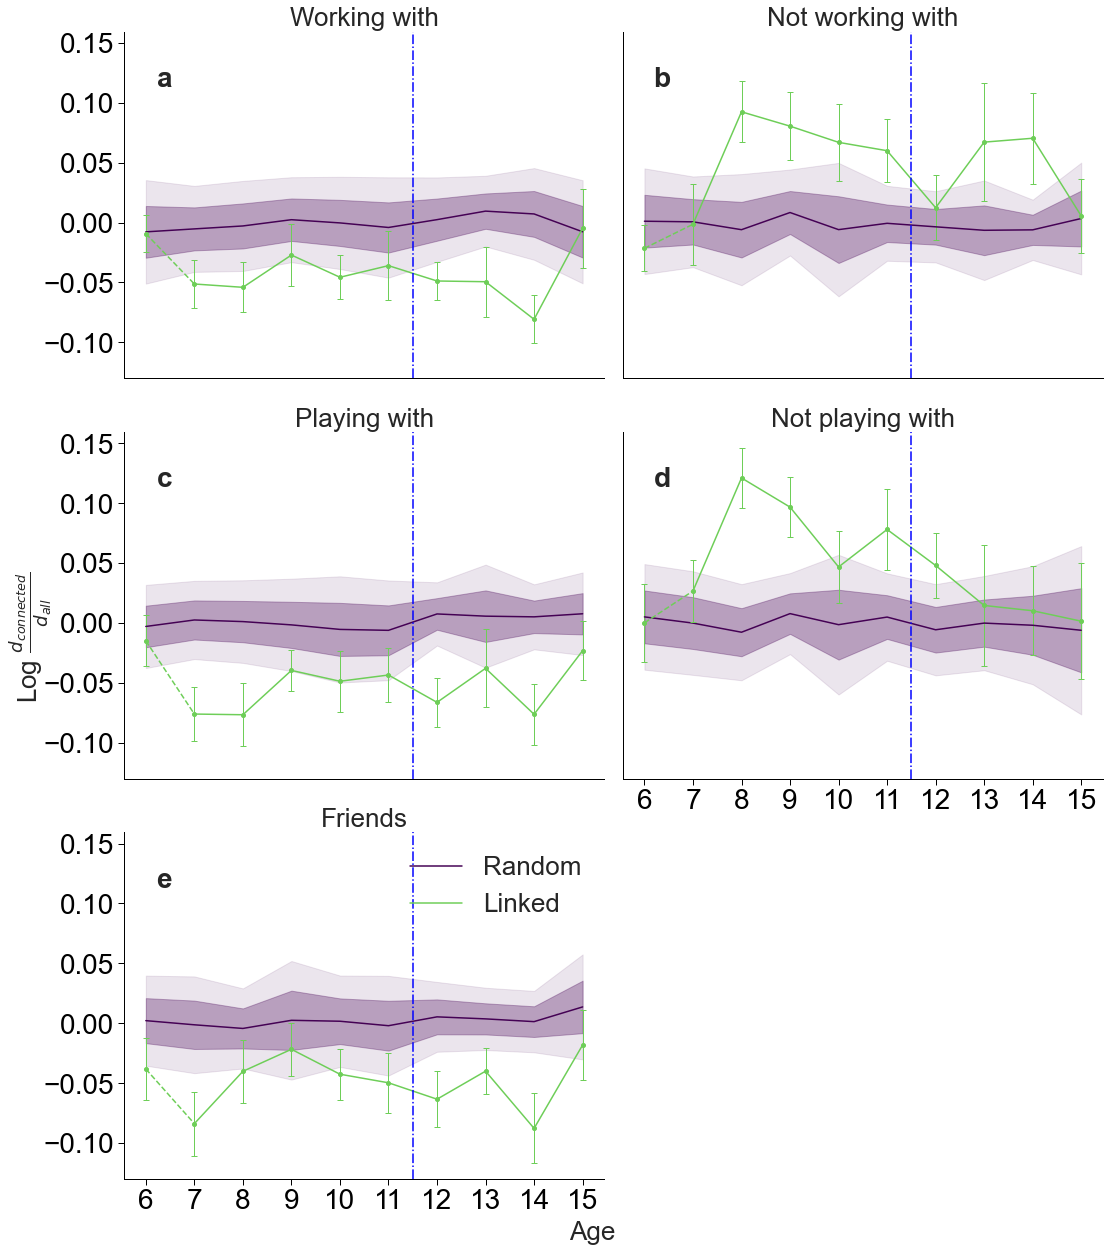

In [20]:
from plot_vars import FONT_BIG
import seaborn as sns
sns.set_theme(font_scale=1.4, style="whitegrid")

questions = temp["question_"].unique()
# questions.sort()

df = temp

# Create a 3x2 grid of subplots with shared y-axis
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 18), sharey=True)

# Flatten the axes array for easier indexing
axes = axes.flatten()

# Letters to identify each subplot
subplot_letters = ['a', 'b', 'c', 'd', 'e', 'f']

for idx, question in enumerate(questions[::-1]):
    ax = axes[idx]

    df_question = df[df['question_'] == question].sort_values(by='period_')
    
    # Separate the data by 'relation_'
    df_linked = df_question[df_question['relation_'] == 'Observed']
    df_not_linked = df_question[df_question['relation_'] == 'Not linked']
    df_rand = df_question[df_question['relation_'] == 'Random']
    
    # Plot for random (null model)
    ax.plot(df_rand['period_'], df_rand['dist_mean'], label='Random', color=colours[1])
    ax.fill_between(df_rand['period_'], 
                   df_rand['dist_mean'] - df_rand['ci1'] * np.sqrt(df_rand['dist_count']), 
                   df_rand['dist_mean'] + df_rand['ci1'] * np.sqrt(df_rand['dist_count']), 
                   alpha=0.3, color=colours[1])
    ax.fill_between(df_rand['period_'], 
                   df_rand['dist_mean'] - df_rand['ci2'] * np.sqrt(df_rand['dist_count']), 
                   df_rand['dist_mean'] + df_rand['ci2'] * np.sqrt(df_rand['dist_count']), 
                   alpha=0.1, color=colours[1])
    
    # Plot for 'Linked' with transition period
    periods = df_linked['period_'].values
    means = df_linked['dist_mean'].values
    
    # Find indices for transition period
    pre_transition_idx = np.where(periods == 6)[0][0]  # Index for grade 6
    post_transition_idx = np.where(periods == 7)[0][0]  # Index for grade 7
    
    # Plot first solid segment (up to 6)
    ax.plot(periods[:pre_transition_idx + 1], 
           means[:pre_transition_idx + 1], 
           color=colours[0], label='Linked')
    
    # Plot dashed transition segment (6-7)
    ax.plot(periods[pre_transition_idx:post_transition_idx + 1],
           means[pre_transition_idx:post_transition_idx + 1],
           color=colours[0], linestyle='--')
    
    # Plot final solid segment (7 onwards)
    ax.plot(periods[post_transition_idx:],
           means[post_transition_idx:],
           color=colours[0])
    
    # Add points and error bars for Linked data
    ax.errorbar(df_linked['period_'], df_linked['dist_mean'],
               yerr=df_linked['ci1'], fmt='o',
               color=colours[0], capsize=3, markersize=4,
               elinewidth=1, capthick=1)
    
    # Labels and title
    ax.set_title(question, fontsize=26)
    ax.legend(loc=(0.7, 0.1))
    ax.grid(False)
    
    if idx not in [3, 4]:
        ax.set_xticklabels([])
    
    # Add x-axis labels only for the bottom plots
    if idx in [3, 4]:
        ax.set_xticks(df_linked['period_'].unique())
        ax.tick_params(axis='x', which='both', bottom=True, labelbottom=True, labelsize=FONT_BIG)
        
    # Add y-axis ticks only for the left plots
    if idx in [0, 2, 4]:
        ax.tick_params(axis='y', which='both', left=True, labelleft=True, labelsize=FONT_BIG)
        
    # Remove most legends
    if idx < len(questions) - 1:
        ax.get_legend().remove()
    else:
        ax.legend(loc='upper right', fontsize=26, frameon=False)
    
    # Add subplot letter identifier
    add_plot_labels(ax, subplot_letters[idx])
    
    # vertical line separating primary and secondary school
    ax.axvline(11.5, color='blue', linestyle='-.')
    
    # Hide the right and top spines
    ax.spines[['right', 'top']].set_visible(False)
    ax.spines[['left', 'bottom']].set_linewidth(1)

# Hide the last (empty) subplot
axes[-1].axis('off')

# paint the axes in black
paint_it_black(axes)

# Add a common y-axis label
fig.text(-0.01, 0.5, r'Log $\frac{d_{connected}}{d_{all}}$', ha='center', va='center', rotation='vertical', fontsize=26)
fig.text(0.51, 0.04, 'Age', ha='center', va='center', fontsize=26)

# Adjust the layout
plt.tight_layout(rect=[0, 0.04, 1, 1])
fig.savefig("plots/figure_4_cog_distances_linked_not_linked_rand.pdf", dpi=300, bbox_inches="tight")

# Who do the high (low) performance choose?

In [14]:
all_melted = all.melt(
        id_vars=["classroom_session_id", "student_id", "id", "dist", "period", "group_left", "group_right"], 
        value_vars=["work_yes", "work_no", "play_yes", "play_no", "friend"], 
        var_name="question", 
        value_name="relation"
    )
    # convert the relation column to a categorical variable, saying "Linked" if 1 and "Not linked" if 0
all_melted["relation"] = all_melted["relation"].astype("category")
all_melted["relation"] = all_melted["relation"].cat.rename_categories({
    0: "Not linked",
    1: "Linked"
})
all_melted["period"] = all_melted["period"].astype("int")

In [15]:
# get only linked students
all_melted = all_melted[all_melted["relation"] == "Linked"]
# plot the differences between choosing patterns (group_right) depending on the question and group_left


In [16]:

def plot_stacked_bars(data, **kwargs):
    questions = data['question'].unique()
    for question in questions:
        # Filter data for this question
        question_data = data[data['question'] == question]
        bars_bottom = np.zeros(len(questions))
        # Iterate through each 'group_right' category
        for category in question_data['group_right'].cat.categories:
            # Filter data for this category
            category_data = question_data[question_data['group_right'] == category]
            # Find the index for the question to place the bar correctly
            question_index = np.where(questions == question)[0][0]
            # Plot the bar for this category at the correct question index
            plt.bar(question_index, category_data['percentage'], bottom=bars_bottom[question_index], 
                    color=color_map[category], label=category)
            # Update the bottom position for the next category
            bars_bottom[question_index] += category_data['percentage'].values

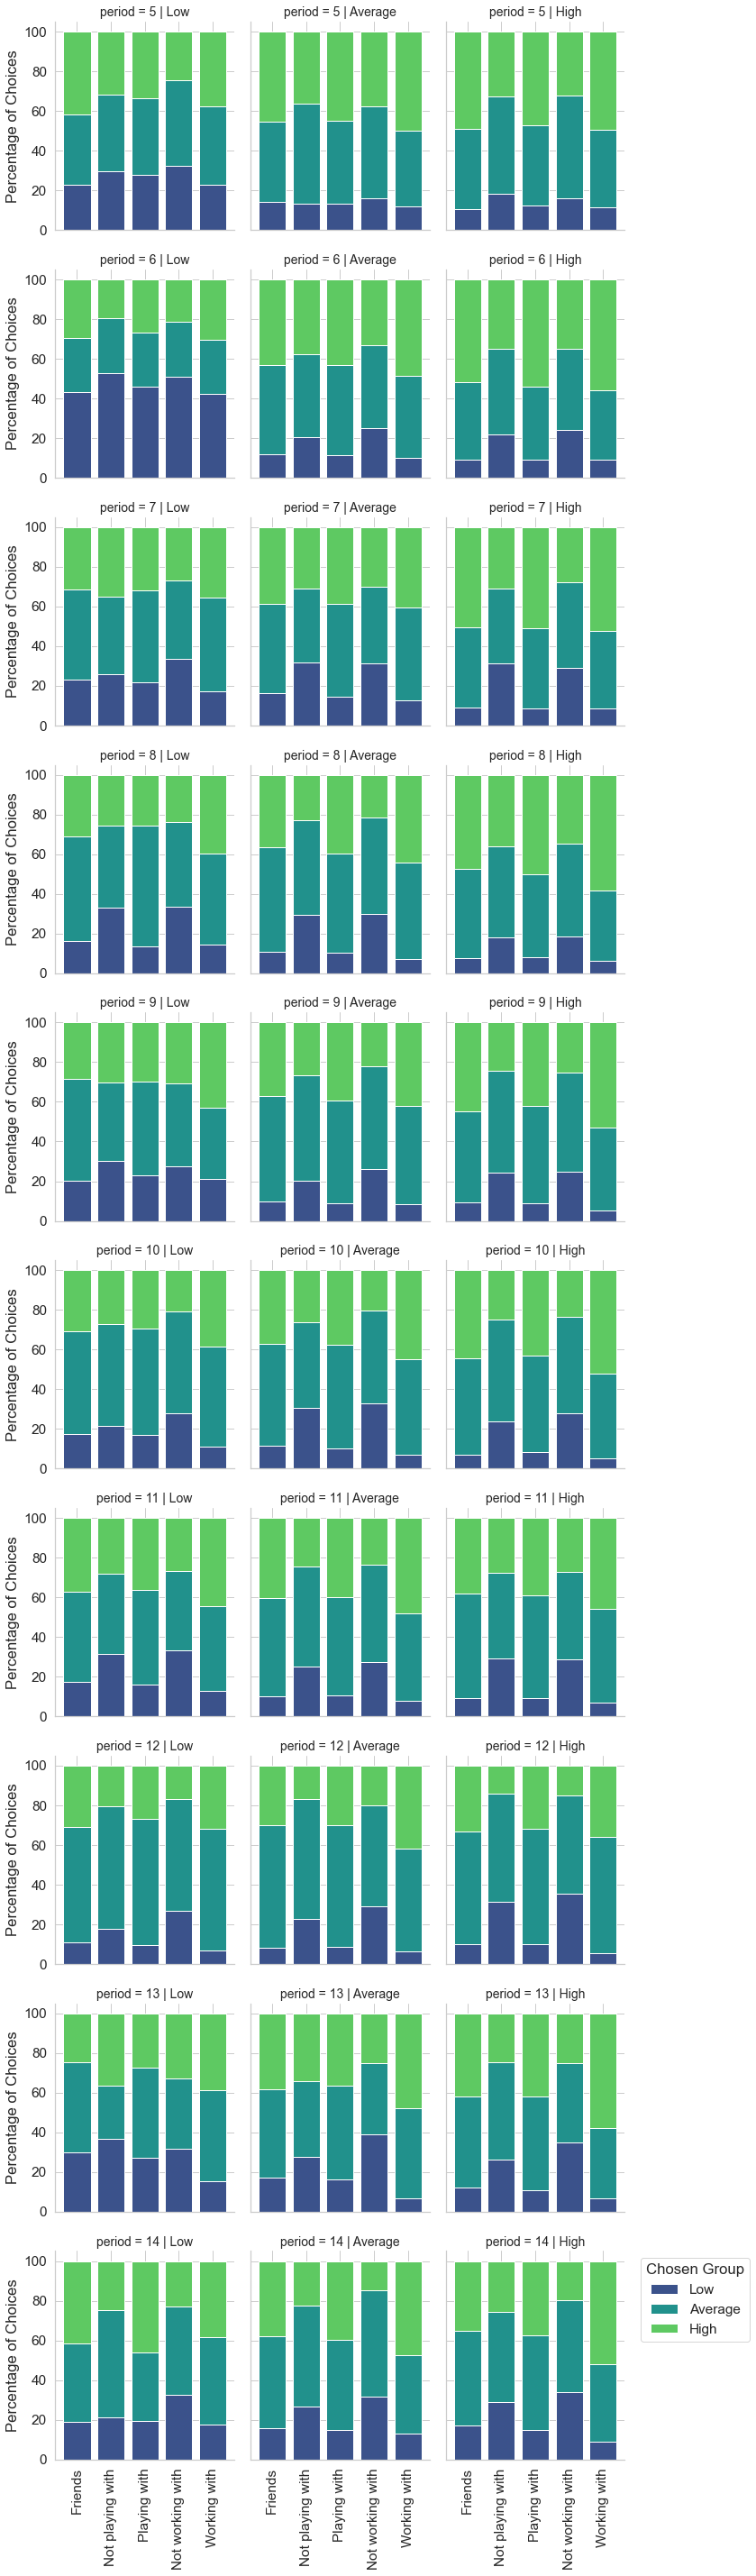

In [17]:
# Aggregate the data to count the number of choices between groups for each question
agg_data = all_melted.groupby(['period', 'question', 'group_left', 'group_right']).size().reset_index(name='count')
agg_data['group_left'] = pd.Categorical(agg_data['group_left'], categories=['Low', 'Average', 'High'], ordered=True)
agg_data['group_right'] = pd.Categorical(agg_data['group_right'], categories=['Low', 'Average', 'High'], ordered=True)

# Define a consistent color palette for 'group_right' categories
palette = sns.color_palette('viridis', n_colors=agg_data['group_right'].nunique())

# Map 'group_right' categories to colors
color_map = {category: color for category, color in zip(agg_data['group_right'].cat.categories, palette)}


# Calculate total counts for each 'group_left' within each question
total_counts = agg_data.groupby(['period', 'question', 'group_left'])['count'].transform('sum')

# Calculate percentages
agg_data['percentage'] = agg_data['count'] / total_counts * 100

# Create a FacetGrid with questions as facets and bars representing choices from each 'group_left' to 'group_right' in percentages
g = sns.FacetGrid(agg_data, row='period', col='group_left', height=4, sharey=True)
# Map the plotting function to the FacetGrid
g.map_dataframe(plot_stacked_bars)

# Adjust layout, titles, and labels
g.set_titles(col_template="{col_name}", size=14)
g.set_axis_labels("", "Percentage of Choices")

# Adjust x-axis settings
g.set(xticks=np.arange(len(questions)), xticklabels=questions)
g.set_xticklabels(rotation=90)

# Add a legend with the color map
plt.legend(color_map.keys(), title='Chosen Group', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()
# print in pdf
g.savefig("../plots/choices_between_groups.pdf", dpi=300, bbox_inches="tight")

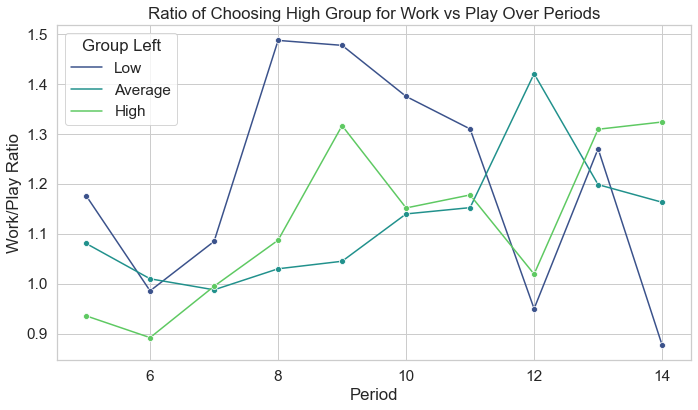

PermissionError: [Errno 13] Permission denied: '../plots/work_play_ratio.pdf'

In [18]:
# Filter the dataset for choices related to working with and playing with the "High" group
work_play_high = agg_data[(agg_data['group_right'] == 'High') & (agg_data['question'].isin(['work_yes', 'play_yes']))]

# Calculate the total choices for each 'group_left', 'question', and 'period'
total_choices = work_play_high.groupby(['period', 'group_left', 'question'])['count'].sum().reset_index()

# Pivot the data to have separate columns for 'work_yes' and 'play_yes'
pivot_data = total_choices.pivot_table(index=['period', 'group_left'], columns='question', values='count').reset_index()

# Calculate the ratio of choices for working with the "High" group to playing with the "High" group
pivot_data['work_play_ratio'] = pivot_data['work_yes'] / pivot_data['play_yes']

# Plotting the ratio over period for each 'group_left' group
fig = plt.figure(figsize=(10, 6))
sns.lineplot(data=pivot_data, x='period', y='work_play_ratio', hue='group_left', marker='o', palette='viridis')

plt.title('Ratio of Choosing High Group for Work vs Play Over Periods')
plt.xlabel('Period')
plt.ylabel('Work/Play Ratio')
plt.legend(title='Group Left')
plt.grid(True)
plt.tight_layout()
plt.show()
# output
fig.savefig("../plots/work_play_ratio.pdf", dpi=300, bbox_inches="tight")

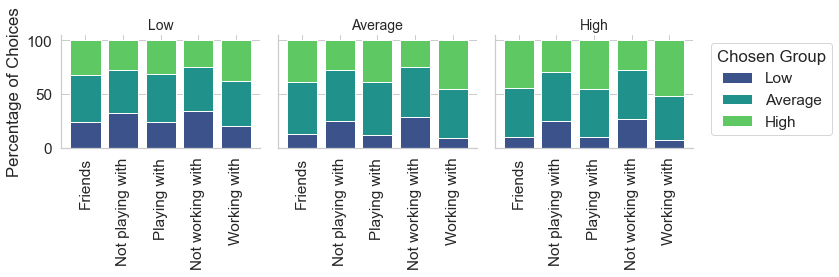

In [132]:
# Aggregate the data to count the number of choices between groups for each question
agg_data = all_melted.groupby(['question', 'group_left', 'group_right']).size().reset_index(name='count')
agg_data['group_left'] = pd.Categorical(agg_data['group_left'], categories=['Low', 'Average', 'High'], ordered=True)
agg_data['group_right'] = pd.Categorical(agg_data['group_right'], categories=['Low', 'Average', 'High'], ordered=True)

# Calculate total counts for each 'group_left' within each question
total_counts = agg_data.groupby(['question', 'group_left'])['count'].transform('sum')

# Calculate percentages
agg_data['percentage'] = agg_data['count'] / total_counts * 100

# Create a FacetGrid with questions as facets and bars representing choices from each 'group_left' to 'group_right' in percentages
g = sns.FacetGrid(agg_data, col='group_left', height=4, sharey=True)
# Map the plotting function to the FacetGrid
g.map_dataframe(plot_stacked_bars)

# Adjust layout, titles, and labels
g.set_titles(col_template="{col_name}", size=14)
g.set_axis_labels("", "Percentage of Choices")

# Adjust x-axis settings
g.set(xticks=np.arange(len(questions)), xticklabels=questions)
g.set_xticklabels(rotation=90)

# Add a legend with the color map
plt.legend(color_map.keys(), title='Chosen Group', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()
# print in pdf
g.savefig("../plots/choices_between_groups_together.pdf", dpi=300, bbox_inches="tight")

In [134]:
# Assuming 'agg_data' already has 'period', 'group_left', 'group_right', 'question', and 'count' columns

# Filter the dataset for choices related to working with and playing with the "High" group
work_play_high = agg_data[(agg_data['group_right'] == 'High') & (agg_data['question'].isin(['work_yes', 'play_yes']))]

# Calculate the total choices for each 'group_left', 'question', and 'period'
total_choices = work_play_high.groupby(['period', 'group_left', 'question'])['count'].sum().reset_index()

# Pivot the data to have separate columns for 'work_yes' and 'play_yes'
pivot_data = total_choices.pivot_table(index=['period', 'group_left'], columns='question', values='count').reset_index()

# Calculate the ratio of choices for working with the "High" group to playing with the "High" group
pivot_data['work_play_ratio'] = pivot_data['work_yes'] / pivot_data['play_yes']

# Plotting the ratio over period for each 'group_left' group
plt.figure(figsize=(10, 6))
sns.lineplot(data=pivot_data, x='period', y='work_play_ratio', hue='group_left', marker='o', palette='viridis')

plt.title('Ratio of Choosing High Group for Work vs Play Over Periods')
plt.xlabel('Period')
plt.ylabel('Work/Play Ratio')
plt.legend(title='Group Left')
plt.grid(True)
plt.tight_layout()
plt.show()

fig.savefig("../plots/work_play_ratio_together.pdf", dpi=300, bbox_inches="tight")

KeyError: 'period'